In [34]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

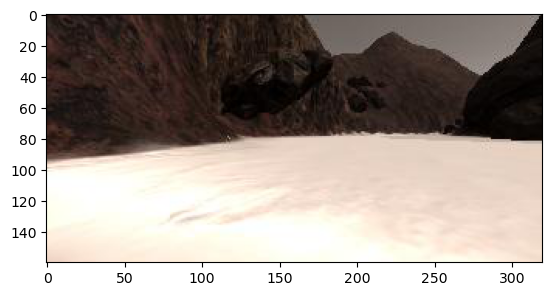

In [35]:
#Taking a Random image from pictures taken by the rover camera to start implementing 
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

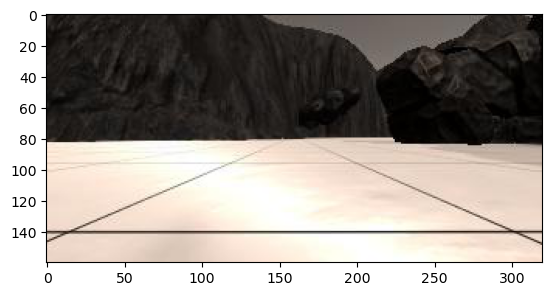

In [36]:
#Using Grid to make each grid have a 1 m^2 
#and to use each grid as a equilibrium square for the bird eye view 

grid = '../calibration_images/example_grid1.jpg'
grid_img = mpimg.imread(grid)

fig = plt.figure()
plt.imshow(grid_img)

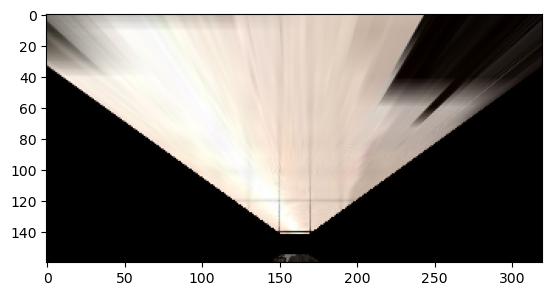

In [37]:
#TO acheive our goal we must define source and destination points for perspective transform
#Our src is the gird 1 m^2 but in rover camera view
#Our dst is the 1 m^2 but in the bird view
#So wraped image is after applying the filter and PerspectiveTransform
#dst_size is the distance between the camera and the wraped image
#bottom offset is the distance between the 0 - 300 axis and camera view 

def perspect_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    return warped

dst_size=10
bottom_offset = 20
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)

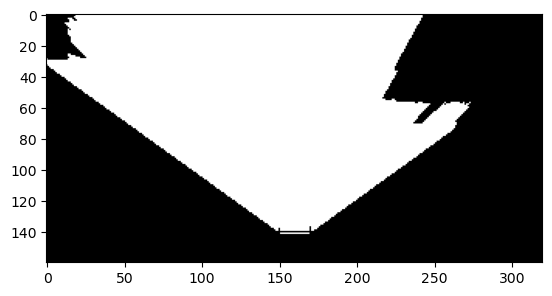

In [38]:
#AFter we get the bird eye in the last step 
#we must to threshold the image to start using it 
#we use 153,135,123 as it is the threshold of the rover to pass or not pass
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

thresh = color_thresh(warped, (153, 135, 123))
plt.imshow(thresh, cmap="gray")

/tmp/ipykernel_6608/804624665.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
/tmp/ipykernel_6608/804624665.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)


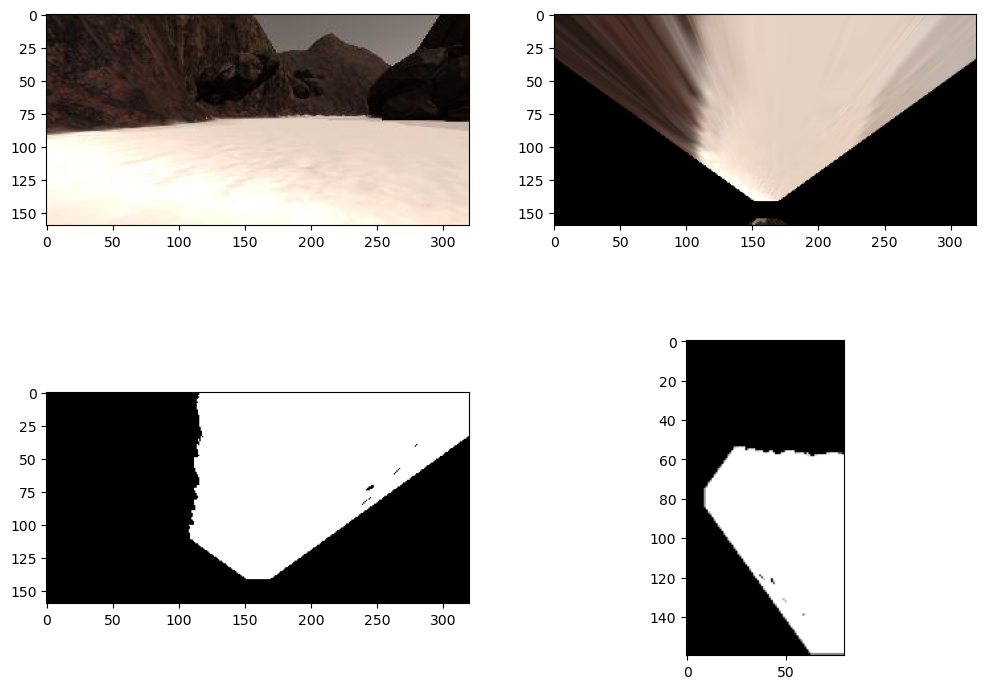

In [39]:
 # Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel


# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

rov_img = np.zeros((321, 161))
for idx, i in np.ndenumerate(xpix):
    x = int(160 - ypix[idx])
    y = int(xpix[idx])
    rov_img[x, y] = 255
rov_img_resized = cv2.resize(rov_img,(80, 160), cv2.INTER_CUBIC)
# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
# plt.plot(xpix, ypix, '.')
# plt.ylim(-160, 160)
# plt.xlim(0, 160)
# arrow_length = 100
# x_arrow = arrow_length * np.cos(mean_dir)
# y_arrow = arrow_length * np.sin(mean_dir)
# plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
plt.imshow(rov_img_resized, cmap="gray")

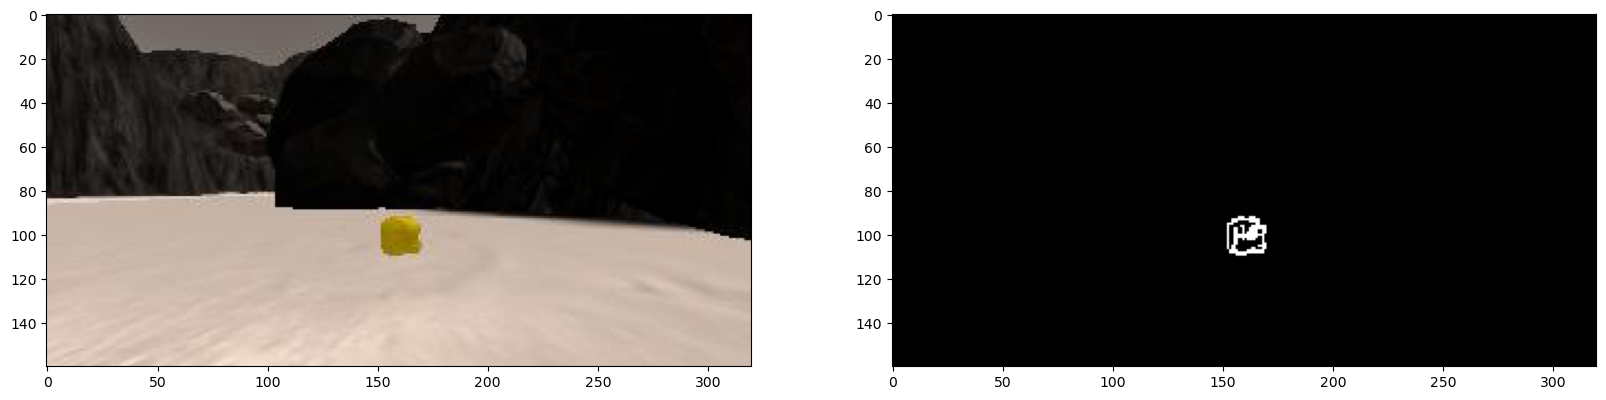

In [26]:
#Grab a random image for a rock
#by using color pick we know that the average scale of """mountain""" is < (45,47,39)
################################################################# ------------Threshold between rock and mountain
#so threshold for not mountain will be here as (100,100,0)
#by using color pick we know that the average scale of """Rock"""  is (150,121,0)
#so threshold for not rock will be here as (1 - (0,0,70)) --> our fault is using this threshold as (180,160,60) 
#as it considering the rock and mountain as a one object and indicate only the ground 
#so we need to subtract the whole image from the mountain to find the rock only
################################################################# ------------Threshold between rock and ground
#by using color pick we know that the average scale of """ground""" is > (212 ,193,179)
r = '../calibration_images/example_rock1.jpg'
rock = mpimg.imread(r)

def rock_thresh(img):
    not_mountain = color_thresh(img, (100,100,0))
    not_nav = 1- color_thresh(img, (0,0,70))
    rock = np.zeros(not_nav.shape)
    for idx, i in np.ndenumerate(not_nav):
        rock[idx] = not_nav[idx] and not_mountain[idx]
    return rock

fig = plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(rock)
plt.subplot(222)
plt.imshow(rock_thresh(rock), cmap="gray")